In [ ]:
!pip install geopandas==0.6.0
!pip install eo-learn
!pip install aenum

In [ ]:
# Firstly, some necessary imports

# Jupyter notebook related
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Built-in modules
import pickle
import sys
import os
import datetime
import itertools
from aenum import MultiValueEnum

# Basics of Python data handling and visualization
import numpy as np
np.random.seed(42)
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import ListedColormap, BoundaryNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from shapely.geometry import Polygon
from tqdm.auto import tqdm

# Machine learning 
import lightgbm as lgb
from sklearn.externals import joblib
from sklearn import metrics
from sklearn import preprocessing

# Imports from eo-learn and sentinelhub-py
from eolearn.core import EOTask, EOPatch, LinearWorkflow, FeatureType, OverwritePermission, \
    LoadTask, SaveTask, EOExecutor, ExtractBandsTask, MergeFeatureTask
from eolearn.io import SentinelHubInputTask, ExportToTiff, ImportFromTiff
from eolearn.mask import AddMultiCloudMaskTask, AddValidDataMaskTask
from eolearn.geometry import VectorToRaster, PointSamplingTask, ErosionTask
from eolearn.features import LinearInterpolation, SimpleFilterTask, NormalizedDifferenceIndexTask
from sentinelhub import UtmZoneSplitter, BBox, CRS, DataSource, BBoxSplitter

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
!git clone https://github.com/sentinel-hub/eo-learn.git

Cloning into 'eo-learn'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 9656 (delta 12), reused 21 (delta 10), pack-reused 9623
Receiving objects: 100% (9656/9656), 391.12 MiB | 14.88 MiB/s, done.
Resolving deltas: 100% (5917/5917), done.
Checking out files: 100% (333/333), done.


In [ ]:
ls

eo-learn/  sample_data/


In [ ]:
cd 'eo-learn/examples/land-cover-map'

/content/eo-learn/examples/land-cover-map


Dimension of the area is 243184 x 161584 m2


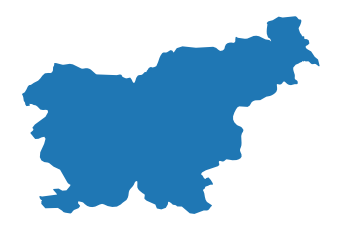

In [ ]:
# Folder where data for running the notebook is stored
DATA_FOLDER = os.path.join('..', '..', 'example_data')

# Load geojson file
country = gpd.read_file(os.path.join(DATA_FOLDER, 'svn_border.geojson'))
country = country.buffer(500)

# Get the country's shape in polygon format
country_shape = country.geometry.values[-1]

# Plot country
country.plot()
plt.axis('off');

# Print size 
print('Dimension of the area is {0:.0f} x {1:.0f} m2'.format(country_shape.bounds[2] - country_shape.bounds[0],
                                                             country_shape.bounds[3] - country_shape.bounds[1]))

In [ ]:
!pip install sentinelhub
!pip install sentinelhub --upgrade

In [ ]:
!sentinelhub.config --instance_id "750cf4b5-6a3e-4258-b1d6-310ed04fe68c"
!sentinelhub.config --sh_client_id "797fff4a-c346-4eec-a503-800c08f6910a"
!sentinelhub.config --sh_client_secret "[yxCcFPFqC!3t2]cHM*7?SeiuFj48cn|yzy4}>GW"
!sentinelhub.config --max_download_attempts 12 --download_sleep_time 18

In [ ]:
!rm -rf  eo-learn/coregistration eo-learn/docs eo-learn/features eo-learn/visualization

In [ ]:
!rm -rf /content/eo-learn/examples/land-cover-map/eoexecution-report-2020_08_02-12_49_40

In [ ]:
!sentinelhub.config --show

{
  "instance_id": "750cf4b5-6a3e-4258-b1d6-310ed04fe68c",
  "sh_client_id": "797fff4a-c346-4eec-a503-800c08f6910a",
  "sh_client_secret": "[yxCcFPFqC!3t2]cHM*7?SeiuFj48cn|yzy4}>GW",
  "sh_base_url": "https://services.sentinel-hub.com",
  "geopedia_wms_url": "https://service.geopedia.world",
  "geopedia_rest_url": "https://www.geopedia.world/rest",
  "aws_access_key_id": "",
  "aws_secret_access_key": "",
  "aws_metadata_url": "https://roda.sentinel-hub.com",
  "aws_s3_l1c_bucket": "sentinel-s2-l1c",
  "aws_s3_l2a_bucket": "sentinel-s2-l2a",
  "opensearch_url": "http://opensearch.sentinel-hub.com/resto/api/collections/Sentinel2",
  "max_wfs_records_per_query": 100,
  "max_opensearch_records_per_query": 500,
  "max_download_attempts": 12,
  "download_sleep_time": 18,
  "download_timeout_seconds": 120,
  "number_of_download_processes": 1
}
Configuration file location: /usr/local/lib/python3.6/dist-packages/sentinelhub/config.json


In [ ]:
# Create the splitter to obtain a list of bboxes
bbox_splitter = UtmZoneSplitter([country_shape], country.crs, 5000)

bbox_list = np.array(bbox_splitter.get_bbox_list())
info_list = np.array(bbox_splitter.get_info_list())

# Prepare info of selected EOPatches
geometry = [Polygon(bbox.get_polygon()) for bbox in bbox_list]
idxs = [info['index'] for info in info_list]
idxs_x = [info['index_x'] for info in info_list]
idxs_y = [info['index_y'] for info in info_list]

gdf = gpd.GeoDataFrame({'index': idxs, 'index_x': idxs_x, 'index_y': idxs_y}, 
                           crs=country.crs, 
                           geometry=geometry)

# select a 5x5 area (id of center patch)
ID = 616

# Obtain surrounding 5x5 patches
patchIDs = []
for idx, [bbox, info] in enumerate(zip(bbox_list, info_list)):
    if (abs(info['index_x'] - info_list[ID]['index_x']) <= 1 and
        abs(info['index_y'] - info_list[ID]['index_y']) <= 1):
        patchIDs.append(idx)

# Check if final size is 3*3
if len(patchIDs) != 3*3:
    print('Warning! Use a different central patch ID, this one is on the border.')
    
# Change the order of the patches (used for plotting later)
patchIDs = np.transpose(np.fliplr(np.array(patchIDs).reshape(3, 3))).ravel()

# save to shapefile
shapefile_name = './grid_slovenia_500x500.gpkg'
gdf.to_file(shapefile_name, driver='GPKG')

In [ ]:
# Comment this out

for idx, bbox in enumerate(bbox_list[patchIDs]):
  print(f'idx = {idx}, bbox = {bbox}')

idx = 0, bbox = 505000.0,5130000.0,510000.0,5135000.0
idx = 1, bbox = 510000.0,5130000.0,515000.0,5135000.0
idx = 2, bbox = 515000.0,5130000.0,520000.0,5135000.0
idx = 3, bbox = 505000.0,5125000.0,510000.0,5130000.0
idx = 4, bbox = 510000.0,5125000.0,515000.0,5130000.0
idx = 5, bbox = 515000.0,5125000.0,520000.0,5130000.0
idx = 6, bbox = 505000.0,5120000.0,510000.0,5125000.0
idx = 7, bbox = 510000.0,5120000.0,515000.0,5125000.0
idx = 8, bbox = 515000.0,5120000.0,520000.0,5125000.0


In [ ]:
for bbox in bbox_list[patchIDs]:
  print(type(bbox))

<class 'sentinelhub.geometry.BBox'>
<class 'sentinelhub.geometry.BBox'>
<class 'sentinelhub.geometry.BBox'>
<class 'sentinelhub.geometry.BBox'>
<class 'sentinelhub.geometry.BBox'>
<class 'sentinelhub.geometry.BBox'>
<class 'sentinelhub.geometry.BBox'>
<class 'sentinelhub.geometry.BBox'>
<class 'sentinelhub.geometry.BBox'>


In [ ]:
patchIDs

array([588, 617, 646, 587, 616, 645, 586, 615, 644])

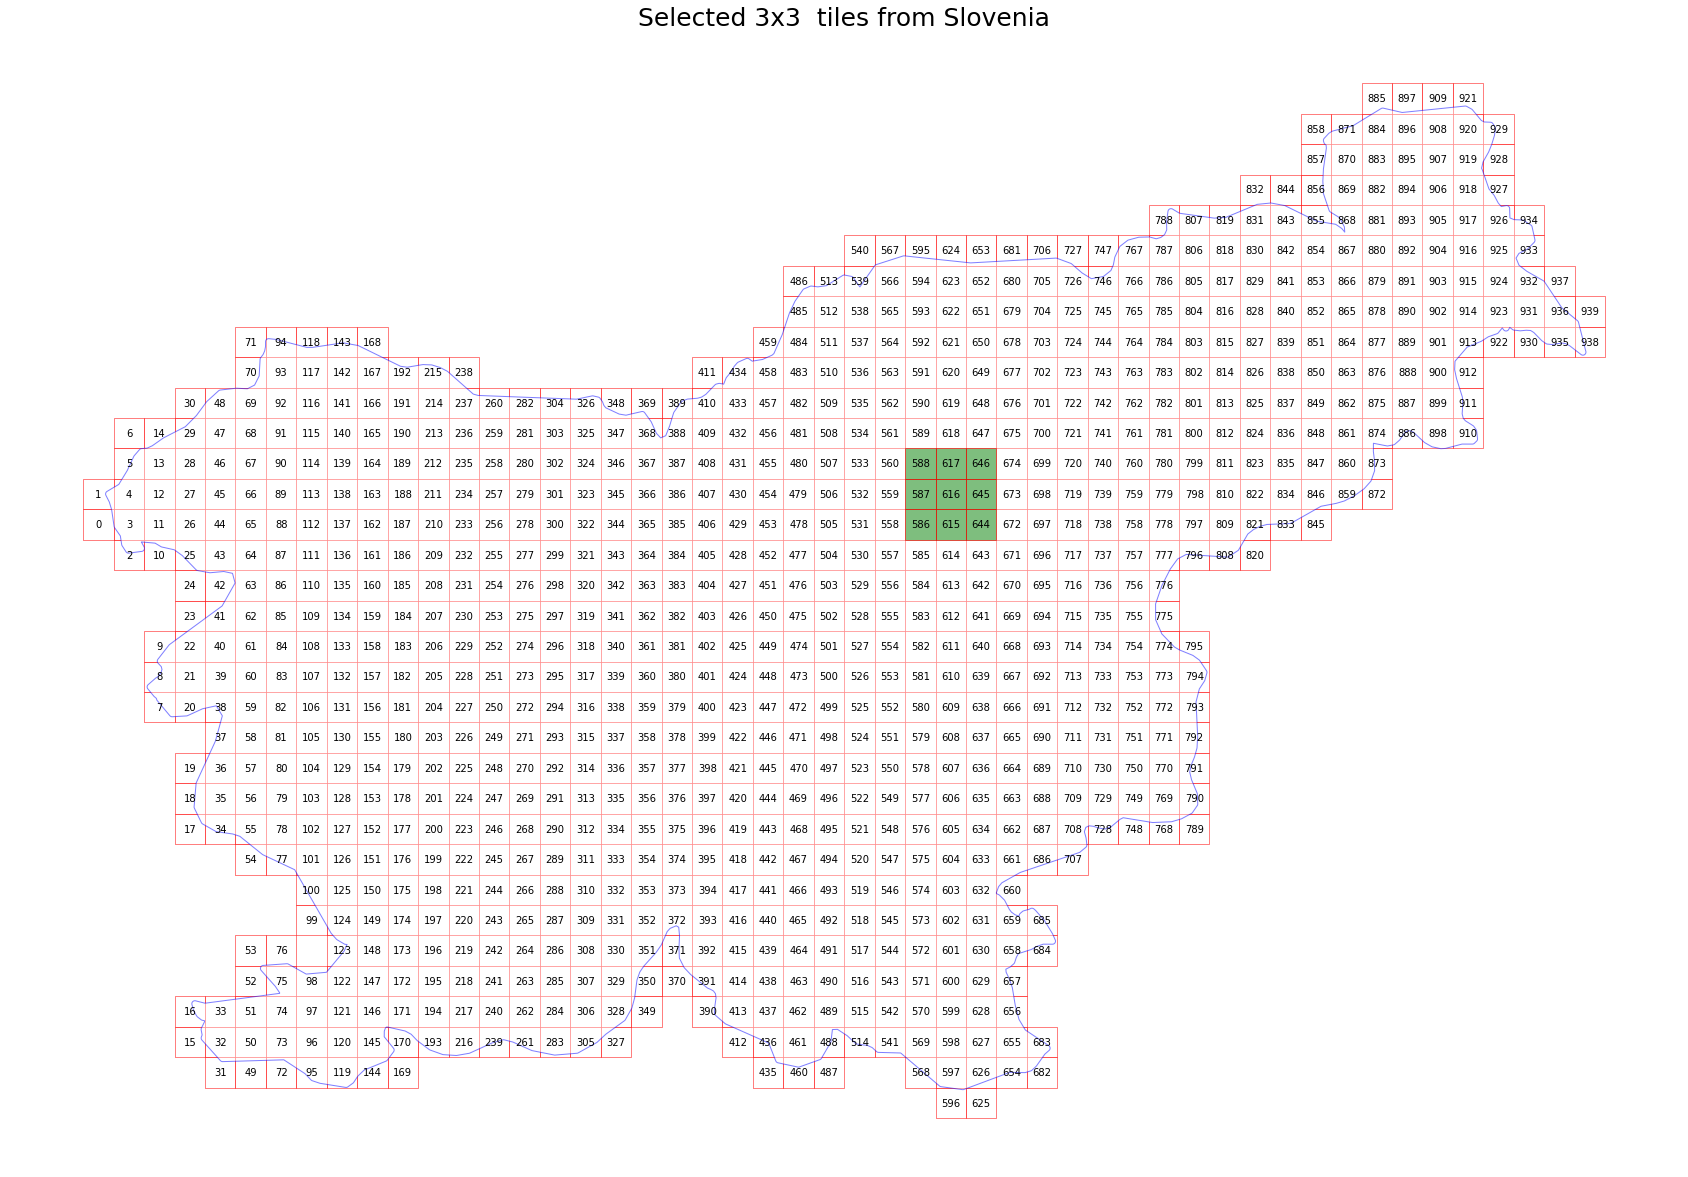

In [ ]:
# figure
fig, ax = plt.subplots(figsize=(30, 30))
gdf.plot(ax=ax,facecolor='w',edgecolor='r',alpha=0.5)
country.plot(ax=ax, facecolor='w',edgecolor='b',alpha=0.5)
ax.set_title('Selected 3x3  tiles from Slovenia', fontsize=25);
for bbox, info in zip(bbox_list, info_list):
    geo = bbox.geometry
    ax.text(geo.centroid.x, geo.centroid.y, info['index'], ha='center', va='center')
    
gdf[gdf.index.isin(patchIDs)].plot(ax=ax,facecolor='g',edgecolor='r',alpha=0.5)

plt.axis('off');

In [ ]:
class SentinelHubValidData:
    """
    Combine Sen2Cor's classification map with `IS_DATA` to define a `VALID_DATA_SH` mask
    The SentinelHub's cloud mask is asumed to be found in eopatch.mask['CLM']
    """
    def __call__(self, eopatch):        
        return np.logical_and(eopatch.mask['IS_DATA'].astype(np.bool), 
                              np.logical_not(eopatch.mask['CLM'].astype(np.bool)))
    
class CountValid(EOTask):   
    """
    The task counts number of valid observations in time-series and stores the results in the timeless mask.
    """
    def __init__(self, count_what, feature_name):
        self.what = count_what
        self.name = feature_name
        
    def execute(self, eopatch):
        eopatch.add_feature(FeatureType.MASK_TIMELESS, self.name, np.count_nonzero(eopatch.mask[self.what],axis=0))
        
        return eopatch

In [ ]:

# TASK FOR BAND DATA
# add a request for S2 bands
# Here we also do a simple filter of cloudy scenes (on tile level)
# s2cloudless masks and probabilities are requested via additional data
band_names = ['B02', 'B03', 'B04', 'B08', 'B11', 'B12']
add_data = SentinelHubInputTask(
    bands_feature=(FeatureType.DATA, 'BANDS'),
    bands = band_names,
    resolution=10,
    maxcc=0.8,
    time_difference=datetime.timedelta(minutes=120),
    data_source=DataSource.SENTINEL2_L1C,
    additional_data=[(FeatureType.MASK, 'dataMask', 'IS_DATA'),
                     (FeatureType.MASK, 'CLM'),
                     (FeatureType.DATA, 'CLP')],
                     max_threads = 3
                     )


# TASKS FOR CALCULATING NEW FEATURES
# NDVI: (B08 - B04)/(B08 + B04)
# NDWI: (B03 - B08)/(B03 + B08)
# NDBI: (B11 - B08)/(B11 + B08)
ndvi = NormalizedDifferenceIndexTask((FeatureType.DATA, 'BANDS'), (FeatureType.DATA, 'NDVI'), 
                                     [band_names.index('B08'), band_names.index('B04')])
ndwi = NormalizedDifferenceIndexTask((FeatureType.DATA, 'BANDS'), (FeatureType.DATA, 'NDWI'), 
                                     [band_names.index('B03'), band_names.index('B08')])
ndbi = NormalizedDifferenceIndexTask((FeatureType.DATA, 'BANDS'), (FeatureType.DATA, 'NDBI'), 
                                     [band_names.index('B11'), band_names.index('B08')])



# TASK FOR VALID MASK
# validate pixels using SentinelHub's cloud detection mask and region of acquisition 
add_sh_valmask = AddValidDataMaskTask(SentinelHubValidData(), 
                                      'IS_VALID' # name of output mask
                                     )

# TASK FOR COUNTING VALID PIXELS
# count number of valid observations per pixel using valid data mask 
count_val_sh = CountValid('IS_VALID', # name of existing mask
                          'VALID_COUNT' # name of output scalar
                         )

# TASK FOR SAVING TO OUTPUT (if needed)
path_out = './eopatches/'
if not os.path.isdir(path_out):
    os.makedirs(path_out)
save = SaveTask(path_out, overwrite_permission=OverwritePermission.OVERWRITE_PATCH)

In [ ]:
class LULC(MultiValueEnum):
    """ Enum class containing basic LULC types
    """
    NO_DATA            = 'No Data',            0,  '#ffffff'
    CULTIVATED_LAND    = 'Cultivated Land',    1,  '#ffff00'
    FOREST             = 'Forest',             2,  '#054907'
    GRASSLAND          = 'Grassland',          3,  '#ffa500'
    SHRUBLAND          = 'Shrubland',          4,  '#806000'
    WATER              = 'Water',              5,  '#069af3'
    WETLAND            = 'Wetlands',           6,  '#95d0fc'
    TUNDRA             = 'Tundra',             7,  '#967bb6'
    ARTIFICIAL_SURFACE = 'Artificial Surface', 8,  '#dc143c'
    BARELAND           = 'Bareland',           9,  '#a6a6a6'
    SNOW_AND_ICE       = 'Snow and Ice',       10, '#000000'
    
    @property
    def id(self):
        """ Returns an ID of an enum type

        :return: An ID
        :rtype: int
        """
        return self.values[1]

    @property
    def color(self):
        """ Returns class color

        :return: A color in hexadecimal representation
        :rtype: str
        """
        return self.values[2]


def get_bounds_from_ids(ids):
    bounds = []
    for i in range(len(ids)):
        if i < len(ids) - 1:
            if i == 0:
                diff = (ids[i + 1] - ids[i]) / 2
                bounds.append(ids[i] - diff)
            diff = (ids[i + 1] - ids[i]) / 2
            bounds.append(ids[i] + diff)
        else:
            diff = (ids[i] - ids[i - 1]) / 2
            bounds.append(ids[i] + diff)
    return bounds
    

# Reference colormap things
lulc_bounds = get_bounds_from_ids([x.id for x in LULC])
lulc_cmap = ListedColormap([x.color for x in LULC], name="lulc_cmap")
lulc_norm = BoundaryNorm(lulc_bounds, lulc_cmap.N)

In [ ]:
# takes some time due to the large size of the reference data
land_use_ref_path = os.path.join(DATA_FOLDER, 'land_use_10class_reference_slovenia_partial.gpkg')
land_use_ref = gpd.read_file(land_use_ref_path)

rasterization_task = VectorToRaster(land_use_ref, (FeatureType.MASK_TIMELESS, 'LULC'),
                                    values_column='lulcid', raster_shape=(FeatureType.MASK, 'IS_DATA'),
                                    raster_dtype=np.uint8)

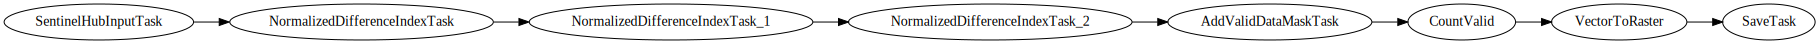

In [ ]:
# Define the workflow
workflow = LinearWorkflow(
    add_data,
    ndvi,
    ndwi,
    ndbi,
    add_sh_valmask,
    count_val_sh,
    rasterization_task,
    save
)

# Let's visualize it
workflow.dependency_graph()

In [ ]:
# # Test Code Comment this out
# time_interval = ['2019-01-01', '2019-12-31'] # time interval for the SH request
# execution_args = []
# for idx, bbox in enumerate(bbox_list[patchIDs]):
#     execution_args.append({
#         add_data:{'bbox': bbox, 'time_interval': time_interval},
#         save: {'eopatch_folder': f'eopatch_{idx}'}
#     })

In [ ]:
rm -r /content/eo-learn/examples/land-cover-map/eoexecution-report-2020_08_02-12_44_53

In [ ]:
%%time

# Execute the workflow
time_interval = ['2019-01-01', '2019-12-31'] # time interval for the SH request

# define additional parameters of the workflow
execution_args = []
for idx, bbox in enumerate(bbox_list[patchIDs]):
    execution_args.append({
        add_data:{'bbox': bbox, 'time_interval': time_interval},
        save: {'eopatch_folder': f'eopatch_{idx}'}
    })
    
executor = EOExecutor(workflow, execution_args, save_logs=True)
executor.run(workers=3, multiprocess=True)

executor.make_report()

In [ ]:
# Draw the RGB image
path_out = './eopatches'
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(20, 20))

date = datetime.datetime(2019,7,1)

for i in tqdm(range(len(patchIDs))):
    eopatch = EOPatch.load(f'{path_out}/eopatch_{i}', lazy_loading=True)
    ax = axs[i//3][i%3]
    dates = np.array(eopatch.timestamp)
    closest_date_id = np.argsort(abs(date-dates))[0]
    ax.imshow(np.clip(eopatch.data['BANDS'][closest_date_id][..., [2, 1, 0]] * 3.5, 0, 1))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect("auto")
    del eopatch

fig.subplots_adjust(wspace=0, hspace=0)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
EOPatch.load('./eopatches/eopatch_0/')

EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(93, 500, 500, 6), dtype=float32)
    CLP: numpy.ndarray(shape=(93, 500, 500, 1), dtype=uint8)
    NDBI: numpy.ndarray(shape=(93, 500, 500, 1), dtype=float32)
    NDVI: numpy.ndarray(shape=(93, 500, 500, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(93, 500, 500, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(93, 500, 500, 1), dtype=uint8)
    IS_DATA: numpy.ndarray(shape=(93, 500, 500, 1), dtype=uint8)
    IS_VALID: numpy.ndarray(shape=(93, 500, 500, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LULC: numpy.ndarray(shape=(500, 500, 1), dtype=uint8)
    VALID_COUNT: numpy.ndarray(shape=(500, 500, 1), dtype=int64)
  }
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {
    maxcc: 0.8
    service_type: 'processing'
    size_x: 500
    size_y: 500
    time_difference: datetime.timedelta(0, 7200)
    time_interval: ('2019-01-01T00:00:00', 

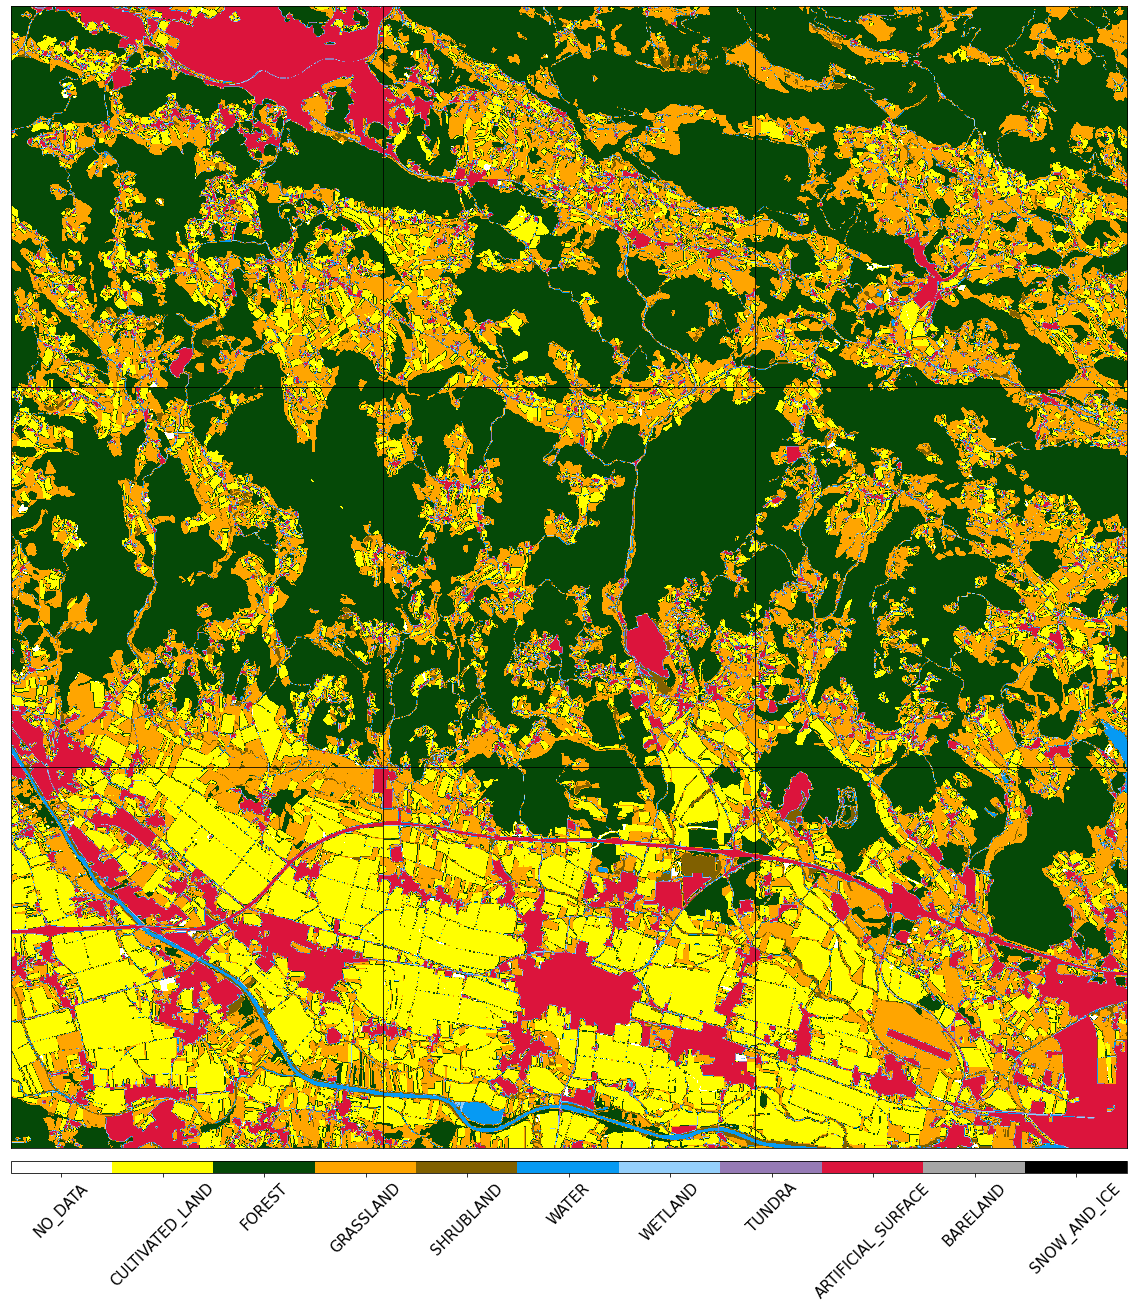

In [ ]:
path_out = './eopatches'

fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(20, 25))

for i in tqdm(range(len(patchIDs))):
    eopatch = EOPatch.load(f'{path_out}/eopatch_{i}', lazy_loading=True)
    ax = axs[i//3][i%3]
    im = ax.imshow(eopatch.mask_timeless['LULC'].squeeze(), cmap=lulc_cmap, norm=lulc_norm)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('auto')
    del eopatch

fig.subplots_adjust(wspace=0, hspace=0)

cb = fig.colorbar(im, ax=axs.ravel().tolist(), orientation='horizontal', pad=0.01, aspect=100)
cb.ax.tick_params(labelsize=20) 
cb.set_ticks([entry.id for entry in LULC])
cb.ax.set_xticklabels([entry.name for entry in LULC], rotation=45, fontsize=15)
plt.show()

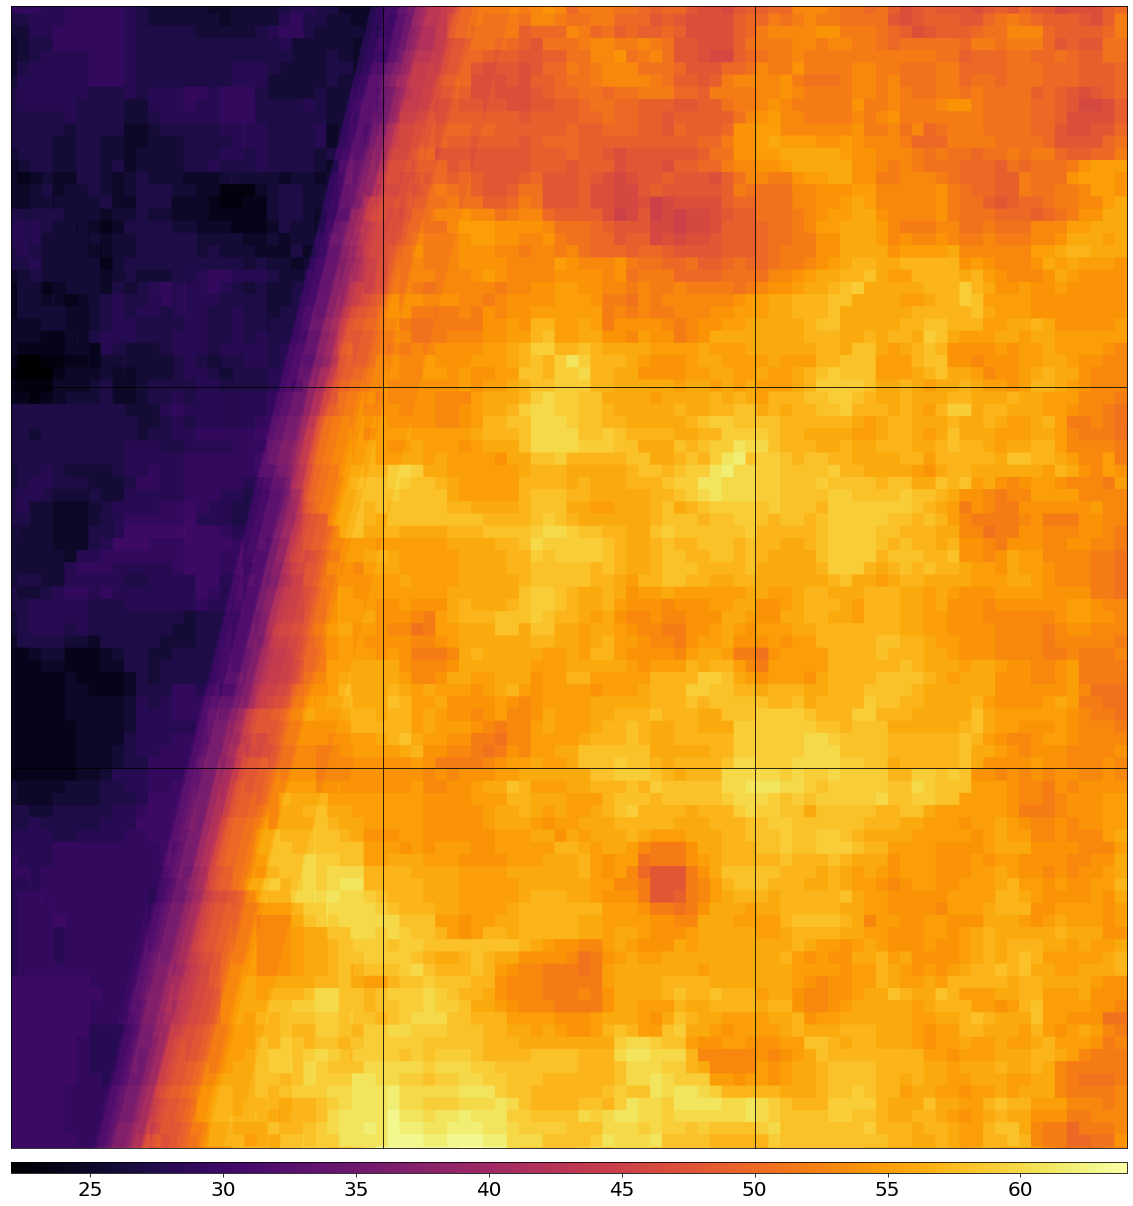

In [ ]:
path_out = './eopatches'

vmin, vmax = None, None
for i in range(len(patchIDs)):
    eopatch = EOPatch.load(f'{path_out}/eopatch_{i}', lazy_loading=True)
    data = eopatch.mask_timeless['VALID_COUNT'].squeeze()
    vmin = np.min(data) if vmin is None else (np.min(data) if np.min(data) < vmin else vmin)
    vmax = np.max(data) if vmax is None else (np.max(data) if np.max(data) > vmax else vmax)

fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(20, 25))
    
for i in tqdm(range(len(patchIDs))):
    eopatch = EOPatch.load(f'{path_out}/eopatch_{i}', lazy_loading=True)
    ax = axs[i//3][i%3]
    im = ax.imshow(eopatch.mask_timeless['VALID_COUNT'].squeeze(), vmin=vmin, vmax=vmax, cmap=plt.cm.inferno)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect("auto")
    del eopatch

fig.subplots_adjust(wspace=0, hspace=0)

cb = fig.colorbar(im, ax=axs.ravel().tolist(), orientation='horizontal', pad=0.01, aspect=100)
cb.ax.tick_params(labelsize=20) 
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice
  app.launch_new_instance()


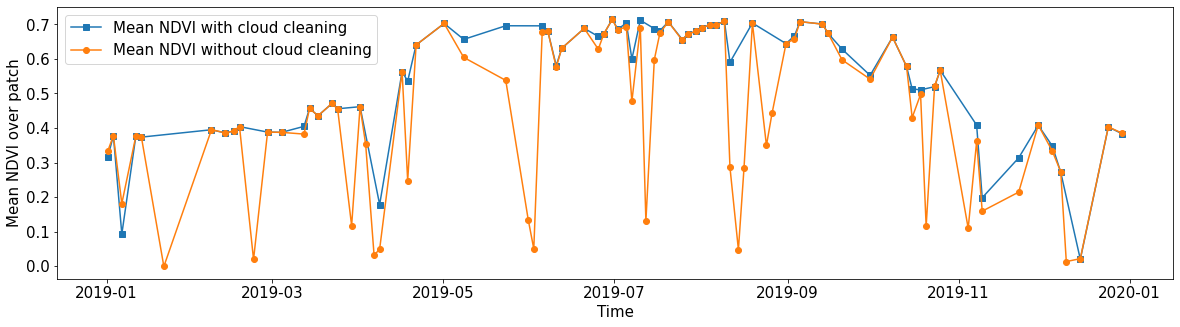

In [ ]:
path_out = './eopatches'

eID = 5
eopatch = EOPatch.load(f'{path_out}/eopatch_{eID}', lazy_loading=True)

ndvi = eopatch.data['NDVI'] # ndvi data cube
mask = eopatch.mask['IS_VALID'] # mask of valid pixels
time = np.array(eopatch.timestamp) # x axis
t, w, h, _ = ndvi.shape 

ndvi_clean = ndvi.copy()
ndvi_clean[~mask] = np.nan # set values of invalid pixels to NaN's

# Calculate means, remove NaN's from means
ndvi_mean = np.nanmean(ndvi.reshape(t, w * h).squeeze(), axis=1) 
ndvi_mean_clean = np.nanmean(ndvi_clean.reshape(t, w * h).squeeze(), axis=1)
time_clean = time[~np.isnan(ndvi_mean_clean)]
ndvi_mean_clean = ndvi_mean_clean[~np.isnan(ndvi_mean_clean)]

fig = plt.figure(figsize=(20,5))
plt.plot(time_clean, ndvi_mean_clean, 's-', label = 'Mean NDVI with cloud cleaning')
plt.plot(time, ndvi_mean, 'o-', label='Mean NDVI without cloud cleaning')
plt.xlabel('Time', fontsize=15)
plt.ylabel('Mean NDVI over patch', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.legend(loc=2, prop={'size': 15});

In [ ]:
path_out = './eopatches'

fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(20, 25))
    
for i in tqdm(range(len(patchIDs))):
    eopatch = EOPatch.load(f'{path_out}/eopatch_{i}', lazy_loading=True)
    ax = axs[i//3][i%3]
    ndvi = eopatch.data['NDVI']
    mask = eopatch.mask['IS_VALID']
    ndvi[~mask] = np.nan
    ndvi_mean = np.nanmean(ndvi, axis=0).squeeze()
    im = ax.imshow(ndvi_mean, vmin=0, vmax=0.8, cmap=plt.get_cmap('YlGn'))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect("auto")
    del eopatch

fig.subplots_adjust(wspace=0, hspace=0)

cb = fig.colorbar(im, ax=axs.ravel().tolist(), orientation='horizontal', pad=0.01, aspect=100)
cb.ax.tick_params(labelsize=20) 
plt.show()

Output hidden; open in https://colab.research.google.com to view.

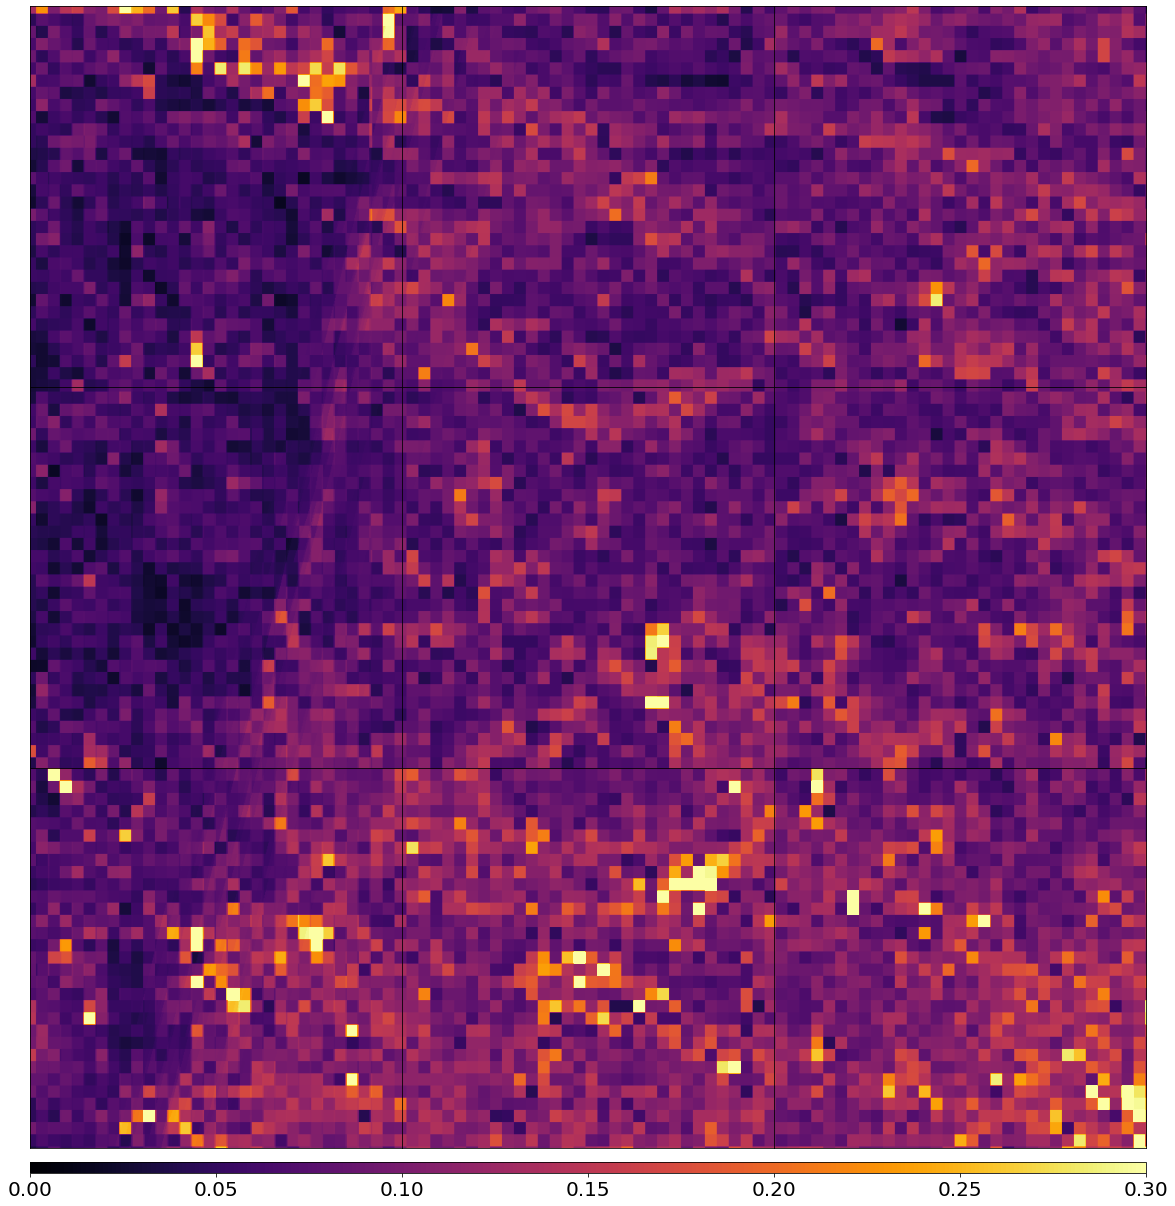

In [ ]:
path_out = './eopatches'

fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(20, 25))

for i in tqdm(range(len(patchIDs))):
    eopatch = EOPatch.load(f'{path_out}/eopatch_{i}', lazy_loading=True)
    ax = axs[i//3][i%3]
    clp = eopatch.data['CLP'].astype(float)/255
    mask = eopatch.mask['IS_VALID']
    clp[~mask] = np.nan
    clp_mean = np.nanmean(clp, axis=0).squeeze()
    im = ax.imshow(clp_mean, vmin=0.0, vmax=0.3, cmap=plt.cm.inferno)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect("auto")
    del eopatch

fig.subplots_adjust(wspace=0, hspace=0)

cb = fig.colorbar(im, ax=axs.ravel().tolist(), orientation='horizontal', pad=0.01, aspect=100)
cb.ax.tick_params(labelsize=20) 
plt.show()

In [ ]:
########################## Training ######################################################

In [ ]:
class ValidDataFractionPredicate:
    """ Predicate that defines if a frame from EOPatch's time-series is valid or not. Frame is valid, if the 
    valid data fraction is above the specified threshold.
    """
    def __init__(self, threshold):
        self.threshold = threshold
        
    def __call__(self, array):
        coverage = np.sum(array.astype(np.uint8)) / np.prod(array.shape)
        return coverage > self.threshold

In [ ]:
# TASK TO LOAD EXISTING EOPATCHES
load = LoadTask(path_out)

# TASK FOR CONCATENATION
concatenate = MergeFeatureTask({FeatureType.DATA: ['BANDS', 'NDVI', 'NDWI', 'NDBI']},
                               (FeatureType.DATA, 'FEATURES'))

# TASK FOR FILTERING OUT TOO CLOUDY SCENES
# keep frames with > 80 % valid coverage
valid_data_predicate = ValidDataFractionPredicate(0.8)
filter_task = SimpleFilterTask((FeatureType.MASK, 'IS_VALID'), valid_data_predicate)

# TASK FOR LINEAR INTERPOLATION
# linear interpolation of full time-series and date resampling
resampled_range = ('2019-01-01', '2019-12-31', 15)
linear_interp = LinearInterpolation(
    'FEATURES', # name of field to interpolate
    mask_feature=(FeatureType.MASK, 'IS_VALID'), # mask to be used in interpolation
    copy_features=[(FeatureType.MASK_TIMELESS, 'LULC')], # features to keep
    resample_range=resampled_range, # set the resampling range
    bounds_error=False # extrapolate with NaN's
)

# TASK FOR EROSION
# erode each class of the reference map
erosion = ErosionTask(mask_feature=(FeatureType.MASK_TIMELESS,'LULC','LULC_ERODED'), disk_radius=1)

# TASK FOR SPATIAL SAMPLING
# Uniformly sample about pixels from patches
n_samples = 125000 # half of pixels
ref_labels = list(range(11)) # reference labels to take into account when sampling
spatial_sampling = PointSamplingTask(
    n_samples=n_samples, 
    ref_mask_feature='LULC_ERODED', 
    ref_labels=ref_labels, 
    sample_features=[  # tag fields to sample
        (FeatureType.DATA, 'FEATURES'),
        (FeatureType.MASK_TIMELESS, 'LULC_ERODED')
    ])

path_out_sampled = './eopatches_sampled'
if not os.path.isdir(path_out_sampled):
    os.makedirs(path_out_sampled)
save = SaveTask(path_out_sampled, overwrite_permission=OverwritePermission.OVERWRITE_PATCH)

In [ ]:
# Define the workflow
workflow = LinearWorkflow(
    load,
    concatenate,
    filter_task,
    linear_interp,
    erosion,
    spatial_sampling,
    save
)

In [ ]:
%%time
   
execution_args = []
for idx in range(len(patchIDs)):
    execution_args.append({
        load: {'eopatch_folder': f'eopatch_{idx}'},
        spatial_sampling: {'seed': 42},
        save: {'eopatch_folder': f'eopatch_{idx}'}
    })
    
executor = EOExecutor(workflow, execution_args, save_logs=True)
executor.run(workers=4, multiprocess=True)

executor.make_report()

In [ ]:
#ls

In [ ]:
# load sampled eopatches
eopatches = []
path_out_sampled = './eopatches_sampled'

for idx in range(len(patchIDs)):
    eopatches.append(EOPatch.load(f'{path_out_sampled}/eopatch_{idx}', lazy_loading=True))    

eopatches = np.array(eopatches)

In [ ]:
# Definition of the train and test patch IDs, take 80 % for train
test_ID = [0, 2, 4]
train_ID = np.argwhere(~np.in1d(patchIDs, patchIDs[test_ID])).squeeze(axis=-1)


# Set the features and the labels for train and test sets
features_train = np.array([eopatch.data['FEATURES_SAMPLED'] for eopatch in eopatches[train_ID]])
labels_train = np.array([eopatch.mask_timeless['LULC_ERODED_SAMPLED'] for eopatch in eopatches[train_ID]])
features_test = np.array([eopatch.data['FEATURES_SAMPLED'] for eopatch in eopatches[test_ID]])
labels_test = np.array([eopatch.mask_timeless['LULC_ERODED_SAMPLED'] for eopatch in eopatches[test_ID]])

# get shape
p1, t, w, h, f = features_train.shape
p2, t, w, h, f = features_test.shape
p = p1 + p2

# reshape to n x m
features_train = np.moveaxis(features_train, 1, 3).reshape(p1 * w * h, t * f)
labels_train = np.moveaxis(labels_train, 1, 2).reshape(p1 * w * h, 1).squeeze()
features_test = np.moveaxis(features_test, 1, 3).reshape(p2 * w * h, t * f)
labels_test = np.moveaxis(labels_test, 1, 2).reshape(p2 * w * h, 1).squeeze()

# remove points with no reference from training (so we dont train to recognize "no data")
mask_train = labels_train == 0
features_train = features_train[~mask_train]
labels_train = labels_train[~mask_train]

# remove points with no reference from test (so we dont validate on "no data", which doesn't make sense)
mask_test = labels_test == 0
features_test = features_test[~mask_test]
labels_test = labels_test[~mask_test]

In [ ]:
features_train.shape

(533212, 225)

In [ ]:
features_train

array([[        nan,         nan,         nan, ...,  0.40936559,
        -0.28867751, -0.32218704],
       [        nan,         nan,         nan, ..., -0.05668038,
         0.2793963 , -0.69267762],
       [        nan,         nan,         nan, ...,  0.56314415,
        -0.45659468, -0.32716957],
       ...,
       [        nan,         nan,         nan, ...,  0.30009115,
        -0.24311747, -0.1089704 ],
       [        nan,         nan,         nan, ...,  0.57168597,
        -0.42153186, -0.30741647],
       [        nan,         nan,         nan, ...,  0.18067823,
        -0.24409111, -0.06303232]])

In [ ]:
# features_train = features_train[np.logical_not(np.isnan(features_train))]

features_train = np.nan_to_num(features_train, nan = 10)

In [ ]:
features_train

In [ ]:
features_train = np.reshape(features_train, (533212, 255))

In [ ]:
features_train.shape

(533212, 225)

In [ ]:
%%time

# Set up training classes
labels_unique = np.unique(labels_train)

# Set up the model
# model = lgb.LGBMClassifier(
#     objective='multiclass', 
#     num_class=len(labels_unique), 
#     metric='multi_logloss',
#     random_state=42
# )

from sklearn import svm
model = svm.SVC(kernel = 'rbf', random_state=42)

# train the model
model.fit(features_train, labels_train)

# uncomment to save the model
joblib.dump(model, './model_SI_LULC.pkl')

In [ ]:
# load the model
model_path = './model_SI_LULC.pkl'
model = joblib.load(model_path)

# predict the test labels
plabels_test = model.predict(features_test)

In [ ]:
class_labels = np.unique(labels_test)
class_names = [entry.name for entry in LULC]
mask = np.in1d(plabels_test, labels_test)
pred = plabels_test[mask]
lbls = labels_test[mask]

f1_scores = metrics.f1_score(lbls, pred, labels=class_labels, average=None)
recall = metrics.recall_score(lbls, pred, labels=class_labels, average=None)
precision = metrics.precision_score(lbls, pred, labels=class_labels, average=None) 

print('Classification accuracy {:.1f}%'.format(100 * metrics.accuracy_score(lbls, pred)))
print('Classification F1-score {:.1f}%'.format(100 * metrics.f1_score(lbls, pred, average='weighted')))
print()
print('             Class              =  F1  | Recall | Precision')
print('         --------------------------------------------------')
for idx, lulctype in enumerate([class_names[idx] for idx in class_labels]):
    print('         * {0:20s} = {1:2.1f} |  {2:2.1f}  | {3:2.1f}'.format(lulctype, 
                                                                         f1_scores[idx] * 100, 
                                                                         recall[idx] * 100, 
                                                                         precision[idx] * 100))

Classification accuracy 92.1%
Classification F1-score 92.3%

             Class              =  F1  | Recall | Precision
         --------------------------------------------------
         * CULTIVATED_LAND      = 58.6 |  48.5  | 74.0
         * FOREST               = 98.4 |  97.9  | 98.9
         * GRASSLAND            = 87.4 |  92.5  | 82.7
         * SHRUBLAND            = 3.9 |  8.5  | 2.5
         * WATER                = 3.1 |  48.4  | 1.6
         * ARTIFICIAL_SURFACE   = 91.9 |  89.8  | 94.1


In [ ]:
# Define the plotting function
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues, ylabel='True label', xlabel='Predicted label', filename=None):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    np.set_printoptions(precision=2, suppress=True)
    
    if normalize:
        cm = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis] + np.finfo(np.float).eps)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap, vmin=0, vmax=1)
    plt.title(title, fontsize=20)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",
                 fontsize=12)

    plt.tight_layout()
    plt.ylabel(ylabel, fontsize=20)
    plt.xlabel(xlabel, fontsize=20)

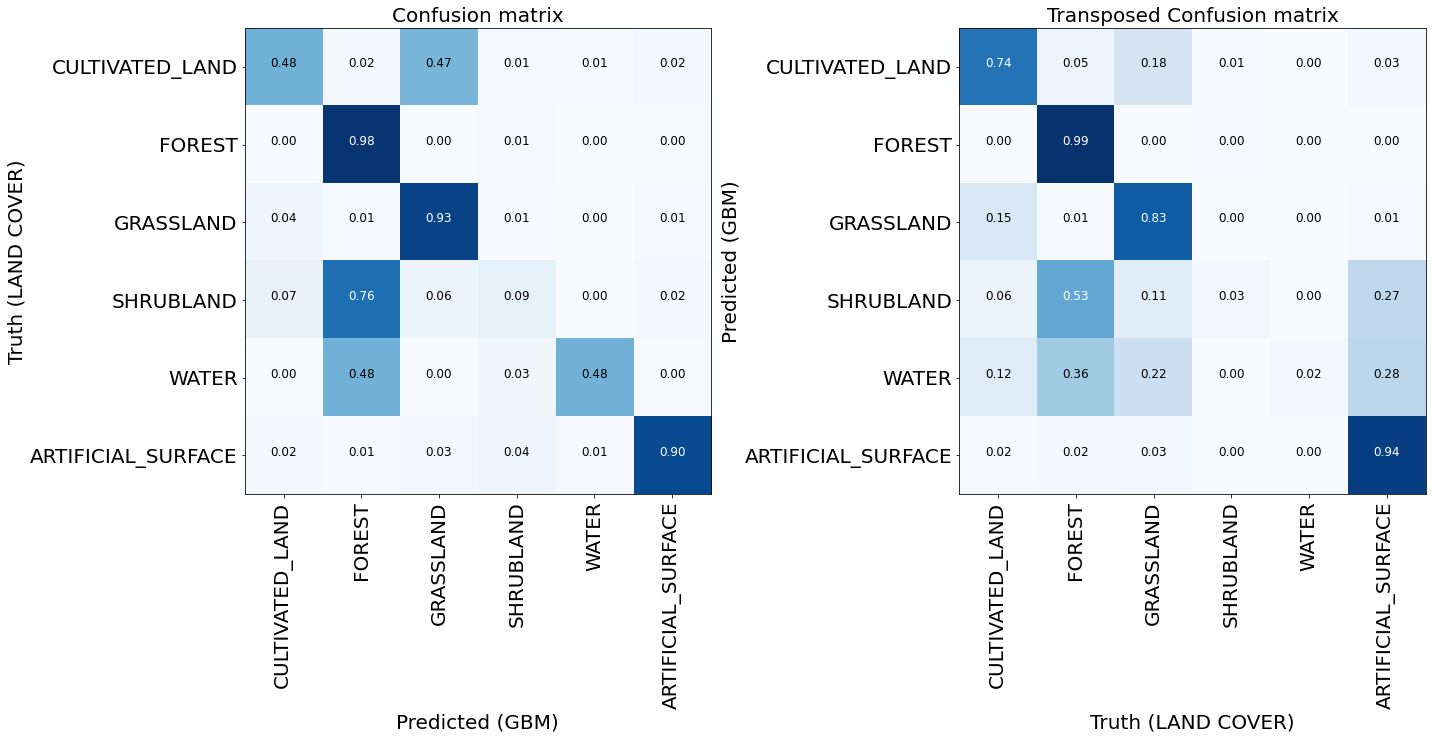

In [ ]:
fig = plt.figure(figsize=(20, 20))

plt.subplot(1, 2, 1)
conf_matrix_gbm = metrics.confusion_matrix(lbls, pred)
plot_confusion_matrix(conf_matrix_gbm, 
                      classes=[name for idx, name in enumerate(class_names) if idx in class_labels], 
                      normalize=True, 
                      ylabel='Truth (LAND COVER)', 
                      xlabel='Predicted (GBM)',
                      title='Confusion matrix');

plt.subplot(1, 2, 2)
conf_matrix_gbm = metrics.confusion_matrix(pred, lbls)
plot_confusion_matrix(conf_matrix_gbm, 
                      classes=[name for idx, name in enumerate(class_names) if idx in class_labels], 
                      normalize=True, 
                      xlabel='Truth (LAND COVER)', 
                      ylabel='Predicted (GBM)',
                      title='Transposed Confusion matrix');

plt.tight_layout()

In [ ]:
rm -r /content/eo-learn/examples/land-cover-map/eoexecution-report-2020_07_03-08_56_19